In [44]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import seaborn as sns
from functools import partial
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
import data_transformers as dt
import model_wrapper as mw
from data_transformers import create_molecular_features, process_molecular_features
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, average_precision_score, accuracy_score
from auxiliary import plotScatterWithIdeal, get_logger
from paths import DATA_DIR, PIPELINES_DIR, MODELS_DIR

from enum import Enum
class ColumnNames(Enum):
    SMILES_COLUMN = "canonical_smiles"
    TARGET_COLUMN = "standard_value_mean"

pd.set_option("display.max_rows", 500)
l = get_logger(logger_name="logger")
USE_CASE = "gyrase"

In [2]:
df = pd.read_parquet(DATA_DIR/USE_CASE/"final_aggregates_chembl_binding_pdb.parquet")
df.head()

,standard_value_min,standard_value_max,standard_value_get_all_levels,standard_value_get_mean,db_id,canonical_smiles,source,activity
0,28000.0,28000.0,[28000.0],2.800000e+04,CHEMBL4,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,chembl,inactive
1,4750000.0,4750000.0,[4750000.0],4.750000e+06,CHEMBL5,CCn1cc(C(=O)O)c(=O)c2ccc(C)nc21,chembl,inactive
2,10600.0,37725.5,"[10600.0, 37725.5]",2.416275e+04,CHEMBL8,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,chembl,inactive
3,6000.0,12500.0,"[6000.0, 8100.0, 10000.0, 11200.0, 12500.0]",1.043333e+04,CHEMBL32,COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(...,chembl,active
4,50000.0,50000.0,[50000.0],5.000000e+04,CHEMBL64,NNC(=O)c1ccncc1,chembl,inactive


* an additional aggregation related to duplicated entry - the explanations are in the notebook related to the data retrieval (data_retrieval_chembl3.0.ipynb), the other project (DNA_GYRAZE) 

In [3]:
def combine_lists(x):
    y = x.dropna()
    if y.empty:
        return np.nan
    else:
        a = [item for item in x]
        ret_val = []
        for item in a: ret_val.extend(item)
        return ret_val

In [4]:
df = df.groupby("db_id").agg({"standard_value_min": min, "standard_value_max": max, "standard_value_get_all_levels": combine_lists, "db_id": min,
"canonical_smiles": min, "source": min})

In [5]:
df["standard_value_mean"] = df["standard_value_get_all_levels"].apply(lambda x: np.array(x).mean())
df["standard_value_mean"] = df["standard_value_mean"].astype(float)
df.head()

,standard_value_min,standard_value_max,standard_value_get_all_levels,db_id,canonical_smiles,source,standard_value_mean
db_id,,,,,,,
50117914,5.0,9400.0,"[5.0, 7990.0, 9400.0]",50117914,COc1c(N2CCNC(C)C2)c(F)cc2c1n(cc(C(O)=O)c2=O)C1CC1,bindingpdb,5798.333333
50131428,9200.0,9200.0,[9200.0],50131428,COc1c(N2CC3CCCNC3C2)c(F)cc2C(=O)C(CN(C3CC3)c12...,bindingpdb,9200.000000
50131445,52000.0,52000.0,[52000.0],50131445,COC(=O)c1cn2[C@@H](C)COc3c(N4CCN(C)CC4)c(F)cc(...,bindingpdb,52000.000000
50330327,2900.0,2900.0,[2900.0],50330327,COc1c(N2CC[C@H](C2)C(C)(C)N)c(F)cc2c1n(C1CC1)c...,bindingpdb,2900.000000
50490565,48400.0,48400.0,[48400.0],50490565,CCOC(=O)C1CN(CCN1)c1c(F)cc2c(c1OC)n(cc(C(O)=O)...,bindingpdb,48400.000000


In [6]:
df[df["db_id"].duplicated(keep=False)]

,standard_value_min,standard_value_max,standard_value_get_all_levels,db_id,canonical_smiles,source,standard_value_mean
db_id,,,,,,,


# QED regression

## Training

In [16]:
TRAINING_CONFIGURATION_FILE = "QED_training_gyrase_regression.json"
MODEL_FILE = "QED_gyrase_regressor.model"
with open(PIPELINES_DIR/TRAINING_CONFIGURATION_FILE, "r") as f:
    training_conf = json.load(f)
configuration_train = training_conf["training_aux_data"]

prediction_methodology = training_conf["prediction_methodology"]
prediction_type=training_conf["prediction_type"]

model_wrapper = mw.model_wrapper.M_XGBoost(prediction_type=prediction_type, pipeline_configuration=None)
model_wrapper.Load(MODELS_DIR/MODEL_FILE)

2022-07-31 08:36:52,320 - logger - INFO - Scaler constructor...


2022-07-31 08:36:54,760 - logger - INFO - CreateFPS fit...
2022-07-31 08:36:54,762 - logger - INFO - CreateFPS transform...
100%|██████████| 318/318 [00:01<00:00, 218.71it/s]
2022-07-31 08:36:57,067 - logger - INFO - Scaler fit...
2022-07-31 08:36:57,076 - logger - INFO - CreateFPS fit...
2022-07-31 08:36:57,077 - logger - INFO - CreateFPS transform...
100%|██████████| 36/36 [00:00<00:00, 212.79it/s]
2022-07-31 08:36:57,355 - logger - INFO - Scaler transform...
2022-07-31 08:36:57,447 - logger - INFO - R2 score on hold-out/external: 0.455872707093285
2022-07-31 08:36:57,448 - logger - INFO - MSE score on hold-out/external: 0.5449584444309475
2022-07-31 08:36:57,449 - logger - INFO - MAE score on hold-out/external: 0.5581887985506779


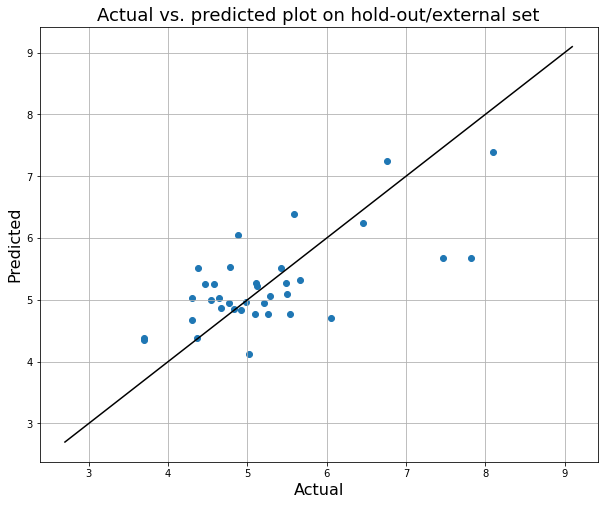

In [17]:
smiles_codes_val = model_wrapper.Data["smiles_codes_val"]
smiles_codes_train = model_wrapper.Data["smiles_codes_train"]
model_wrapper.Pipeline.fit(X=smiles_codes_train, y=None)
X_val = create_molecular_features(pipeline=model_wrapper.Pipeline, smiles_codes=smiles_codes_val)
X_val = process_molecular_features(pipeline=model_wrapper.Pipeline, X=X_val)
y_train_val_pred = model_wrapper.Predict(X_val)
y_train_val = model_wrapper.Data["targets_val"]

plotScatterWithIdeal(y_train_val.values, y_train_val_pred.values, "Actual vs. predicted plot on hold-out/external set")
l.info("R2 score on hold-out/external: %s", r2_score(y_train_val, y_train_val_pred))
l.info("MSE score on hold-out/external: %s", mean_squared_error(y_train_val, y_train_val_pred))
l.info("MAE score on hold-out/external: %s", mean_absolute_error(y_train_val, y_train_val_pred))

2022-07-31 08:36:57,808 - logger - INFO - CreateFPS fit...
2022-07-31 08:36:57,809 - logger - INFO - CreateFPS transform...
100%|██████████| 318/318 [00:01<00:00, 220.22it/s]
2022-07-31 08:37:00,122 - logger - INFO - Scaler fit...
2022-07-31 08:37:00,133 - logger - INFO - CreateFPS fit...
2022-07-31 08:37:00,134 - logger - INFO - CreateFPS transform...
100%|██████████| 318/318 [00:01<00:00, 214.36it/s]
2022-07-31 08:37:02,467 - logger - INFO - Scaler transform...
2022-07-31 08:37:02,541 - logger - INFO - R2 score on training: 0.5351528310209906
2022-07-31 08:37:02,543 - logger - INFO - MSE score on training: 0.2758275830911313
2022-07-31 08:37:02,544 - logger - INFO - MAE score on training: 0.3919682752337298


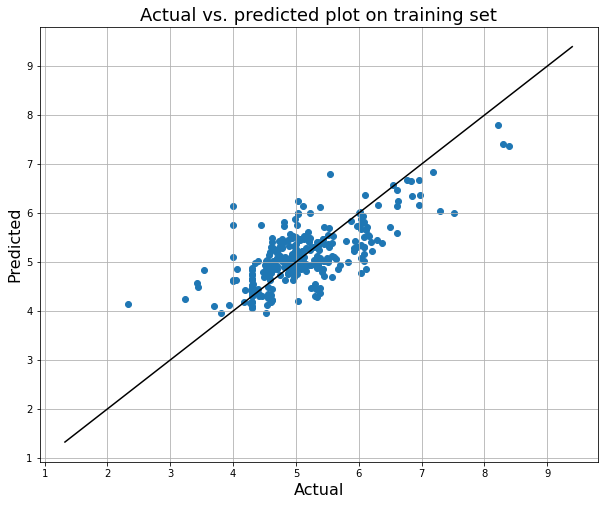

In [18]:
smiles_codes_val = model_wrapper.Data["smiles_codes_val"]
smiles_codes_train = model_wrapper.Data["smiles_codes_train"]
model_wrapper.Pipeline.fit(X=smiles_codes_train, y=None)
X_train = create_molecular_features(pipeline=model_wrapper.Pipeline, smiles_codes=smiles_codes_train)
X_train = process_molecular_features(pipeline=model_wrapper.Pipeline, X=X_train)
y_train_pred = model_wrapper.Predict(X_train)
y_train = model_wrapper.Data["targets_train"]
plotScatterWithIdeal(y_train.values, y_train_pred.values, "Actual vs. predicted plot on training set")
l.info("R2 score on training: %s", r2_score(y_train, y_train_pred))
l.info("MSE score on training: %s", mean_squared_error(y_train, y_train_pred))
l.info("MAE score on training: %s", mean_absolute_error(y_train, y_train_pred))

In [34]:
model_wrapper.Pipeline

Pipeline(steps=[('Molecular features',
                 TurnSmilesIntoFeatures(calculate_fps=False,
                                        chosen_descriptors=[<module 'mordred.SLogP' from '/home/rafalb/miniconda3/envs/rorgammaqsar/lib/python3.8/site-packages/mordred/SLogP.py'>,
                                                            mordred.RingCount.RingCount(None, False, False, True, None),
                                                            <class 'mordred.HydrogenBond.HBondAcceptor'>,
                                                            <class 'mordred.HydrogenBond.HBondD...
                                                            mordred.Weight.Weight(True, False),
                                                            mordred.TopoPSA.TopoPSA(False),
                                                            <module 'mordred.Lipinski' from '/home/rafalb/miniconda3/envs/rorgammaqsar/lib/python3.8/site-packages/mordred/Lipinski.py'>],
                                        meta_descriptors=['QED'],
                                        opt_3d=None)),
                ('Scaling',
                 DataScaling(scaler=StandardScaler(),
                             scaling_features=['SLogP', 'SMR', 'naRing',
                                               'nHBAcc', 'nHBDon', 'nRot', 'MW',
                                               'TopoPSA', 'QED']))])

# QED, Morgan 1024 -> PCA/128 classification

In [45]:
TRAINING_CONFIGURATION_FILE = "QED_FP_PCA128_training_gyrase_classification.json"
with open(PIPELINES_DIR/TRAINING_CONFIGURATION_FILE, "r") as f:
    training_conf = json.load(f)
configuration_train = training_conf["training_aux_data"]

MODEL_FILE = training_conf["model_storage"]["resulting_model"]

prediction_methodology = training_conf["prediction_methodology"]
prediction_type=training_conf["prediction_type"]

model_wrapper = mw.model_wrapper.M_XGBoost(prediction_type=prediction_type, pipeline_configuration=None)
model_wrapper.Load(MODELS_DIR/MODEL_FILE)

2022-07-31 10:58:26,025 - logger - INFO - PCA constructor...


2022-07-31 10:58:28,041 - logger - INFO - CreateFPS fit...
2022-07-31 10:58:28,044 - logger - INFO - CreateFPS transform...
100%|██████████| 318/318 [00:00<00:00, 342.70it/s]
2022-07-31 10:58:29,732 - logger - INFO - Scaler fit...
2022-07-31 10:58:29,936 - logger - INFO - CreateFPS fit...
2022-07-31 10:58:29,938 - logger - INFO - CreateFPS transform...
100%|██████████| 36/36 [00:00<00:00, 289.12it/s]
2022-07-31 10:58:30,210 - logger - INFO - PCA transform...
2022-07-31 10:58:30,323 - logger - INFO - Precision score on hold-out/external: 0.8064516129032258
2022-07-31 10:58:30,326 - logger - INFO - Recall score on hold-out/external: 1.0
2022-07-31 10:58:30,329 - logger - INFO - ROCAUC score on hold-out/external: 0.7272727272727273
2022-07-31 10:58:30,331 - logger - INFO - Average precision score on hold-out/external: 0.8064516129032258
2022-07-31 10:58:30,333 - logger - INFO - Accuracy precision score on hold-out/external: 0.8333333333333334


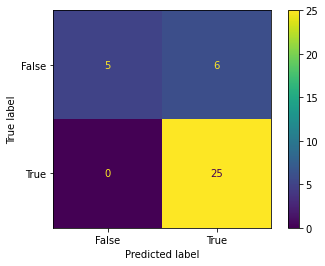

In [46]:
smiles_codes_val = model_wrapper.Data["smiles_codes_val"]
smiles_codes_train = model_wrapper.Data["smiles_codes_train"]
model_wrapper.Pipeline.fit(X=smiles_codes_train, y=None)
X_val = create_molecular_features(pipeline=model_wrapper.Pipeline, smiles_codes=smiles_codes_val)
X_val = process_molecular_features(pipeline=model_wrapper.Pipeline, X=X_val)
y_train_val_pred = model_wrapper.Predict(X_val)
y_train_val = model_wrapper.Data["targets_val"]
ConfusionMatrixDisplay.from_predictions(y_train_val, y_train_val_pred > configuration_train["threshold"])
l.info("Precision score on hold-out/external: %s", precision_score(y_train_val, y_train_val_pred > configuration_train["threshold"]))
l.info("Recall score on hold-out/external: %s", recall_score(y_train_val, y_train_val_pred > configuration_train["threshold"]))
l.info("ROCAUC score on hold-out/external: %s", roc_auc_score(y_train_val, y_train_val_pred > configuration_train["threshold"]))
l.info("Average precision score on hold-out/external: %s", average_precision_score(y_train_val, y_train_val_pred > configuration_train["threshold"]))
l.info("Accuracy precision score on hold-out/external: %s", accuracy_score(y_train_val, y_train_val_pred > configuration_train["threshold"]))

In [48]:
smiles_codes_all = pd.concat([model_wrapper.Data["smiles_codes_train"], model_wrapper.Data["smiles_codes_val"]])
model_wrapper.Pipeline.fit(X=smiles_codes_all, y=None)
X_all = create_molecular_features(pipeline=model_wrapper.Pipeline, smiles_codes=smiles_codes_all)
X_all = process_molecular_features(pipeline=model_wrapper.Pipeline, X=X_all)
y_all =  pd.concat([model_wrapper.Data["targets_train"], model_wrapper.Data["targets_val"]])


2022-07-31 11:00:50,200 - logger - INFO - CreateFPS fit...
2022-07-31 11:00:50,202 - logger - INFO - CreateFPS transform...
100%|██████████| 354/354 [00:01<00:00, 341.16it/s]
2022-07-31 11:00:52,082 - logger - INFO - Scaler fit...
2022-07-31 11:00:52,215 - logger - INFO - CreateFPS fit...
2022-07-31 11:00:52,216 - logger - INFO - CreateFPS transform...
100%|██████████| 354/354 [00:01<00:00, 320.88it/s]
2022-07-31 11:00:54,250 - logger - INFO - PCA transform...


In [49]:
X_all.head()

,SLogP,SMR,naRing,nHBAcc,nHBDon,nRot,MW,TopoPSA,Lipinski,GhoseFilter,...,pca_118,pca_119,pca_120,pca_121,pca_122,pca_123,pca_124,pca_125,pca_126,pca_127
db_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL3085863,4.88450,121.9812,3,6,1,7,439.172976,82.70,1,1,...,0.017109,0.065504,0.071260,0.068591,-0.055914,0.008985,0.071797,0.008718,0.061188,-0.028833
CHEMBL3739454,2.13110,117.3684,3,8,0,7,423.190654,93.74,1,1,...,-0.061998,-0.028477,-0.098146,-0.090671,-0.047290,-0.047248,-0.135538,-0.084020,0.055551,0.094443
CHEMBL3403243,4.47282,110.2694,3,3,2,3,378.185590,57.26,1,1,...,-0.019294,0.001279,0.011432,0.019206,-0.011284,0.066282,-0.037750,0.001271,-0.120381,0.026796
CHEMBL3355808,3.49300,109.2857,3,4,1,3,368.112939,91.73,1,1,...,-0.028928,-0.076947,0.065044,-0.055330,-0.101972,0.082557,-0.042679,-0.172754,-0.028284,-0.206476
CHEMBL3628455,3.77770,115.7980,3,6,2,8,407.184506,83.92,1,1,...,0.001124,-0.051263,-0.018210,-0.005018,0.060336,0.017359,0.063292,0.022369,0.013483,0.056621


<AxesSubplot:>

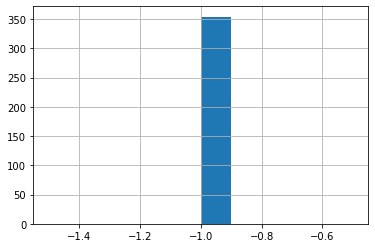

In [83]:
dbs = DBSCAN()
cl = pd.Series(dbs.fit_predict(X_all[model_wrapper.Pipeline["PCA"].PCA_feature_names[:24]]))
cl.hist()

In [90]:
tsne = TSNE(n_components=2, perplexity=15)
tsne_embedding = tsne.fit_transform(X_all[model_wrapper.Pipeline["PCA"].PCA_feature_names[:24]])
tsne_embedding = pd.DataFrame(tsne_embedding, index=X_all.index)
tsne_embedding = pd.concat([tsne_embedding, y_all], axis=1)
tsne_embedding.columns = ["tsne_1", "tsne_2", "active"]
tsne_embedding.head()

/home/rafalb/miniconda3/envs/rorgammaqsar/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/rafalb/miniconda3/envs/rorgammaqsar/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,tsne_1,tsne_2,active
db_id,,,
CHEMBL3085863,8.347580,-4.116239,False
CHEMBL3739454,38.352062,-13.369669,True
CHEMBL3403243,-4.809299,40.477085,True
CHEMBL3355808,3.743963,-21.114794,False
CHEMBL3628455,-45.190208,-8.553498,False


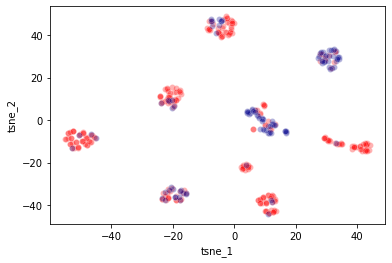

In [91]:
ax = sns.scatterplot(data=tsne_embedding.query("active == 1"), x="tsne_1", y="tsne_2", color='red', alpha=0.3)
ax = sns.scatterplot(data=tsne_embedding.query("active == 0"), x="tsne_1", y="tsne_2", color='darkblue', alpha=0.3)

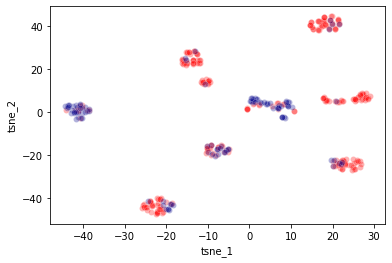

In [89]:
ax = sns.scatterplot(data=tsne_embedding.query("active == 1"), x="tsne_1", y="tsne_2", color='red', alpha=0.3)
ax = sns.scatterplot(data=tsne_embedding.query("active == 0"), x="tsne_1", y="tsne_2", color='darkblue', alpha=0.3)